In [0]:
# Imports
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.ticker import PercentFormatter
import seaborn as sns
import pandas as pd
from pyspark.sql.functions import col, count, mean, desc
import io
import base64
from IPython.display import display, HTML
from pyspark.sql import functions as F
from pyspark.sql.functions import when
from pyspark.sql.functions import col

import pyspark.sql.functions as F
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql.functions import when

In [0]:
# Load OTPW 12-month 2015 into df (same name as 3M notebook)
df = (
    spark.read.format("csv")
    .option("header", "true")
    .option("inferSchema", "true")
    .load("dbfs:/mnt/mids-w261/OTPW_12M/OTPW_12M/OTPW_12M_2015.csv.gz")
).cache()

display(df)
print(df.count(), len(df.columns))


QUARTER DAY_OF_MONTH DAY_OF_WEEK FL_DATE OP_UNIQUE_CARRIER OP_CARRIER_AIRLINE_ID OP_CARRIER TAIL_NUM OP_CARRIER_FL_NUM ORIGIN_AIRPORT_ID ORIGIN_AIRPORT_SEQ_ID ORIGIN_CITY_MARKET_ID ORIGIN ORIGIN_CITY_NAME ORIGIN_STATE_ABR ORIGIN_STATE_FIPS ORIGIN_STATE_NM ORIGIN_WAC DEST_AIRPORT_ID DEST_AIRPORT_SEQ_ID DEST_CITY_MARKET_ID DEST DEST_CITY_NAME DEST_STATE_ABR DEST_STATE_FIPS DEST_STATE_NM DEST_WAC CRS_DEP_TIME DEP_TIME DEP_DELAY DEP_DELAY_NEW DEP_DEL15 DEP_DELAY_GROUP DEP_TIME_BLK TAXI_OUT WHEELS_OFF WHEELS_ON TAXI_IN CRS_ARR_TIME ARR_TIME ARR_DELAY ARR_DELAY_NEW ARR_DEL15 ARR_DELAY_GROUP ARR_TIME_BLK CANCELLED CANCELLATION_CODE DIVERTED CRS_ELAPSED_TIME ACTUAL_ELAPSED_TIME AIR_TIME FLIGHTS DISTANCE DISTANCE_GROUP CARRIER_DELAY WEATHER_DELAY NAS_DELAY SECURITY_DELAY LATE_AIRCRAFT_DELAY FIRST_DEP_TIME TOTAL_ADD_GTIME LONGEST_ADD_GTIME YEAR MONTH origin_airport_name origin_station_name origin_station_id origin_iata_code origin_icao origin_type origin_region origin_station_lat origin_station_lon origin_airport_lat origin_airport_lon origin_station_dis dest_airport_name dest_station_name dest_station_id dest_iata_code dest_icao dest_type dest_region dest_station_lat dest_station_lon dest_airport_lat dest_airport_lon dest_station_dis sched_depart_date_time sched_depart_date_time_UTC four_hours_prior_depart_UTC two_hours_prior_depart_UTC STATION DATE LATITUDE LONGITUDE ELEVATION NAME REPORT_TYPE SOURCE HourlyAltimeterSetting HourlyDewPointTemperature HourlyDryBulbTemperature HourlyPrecipitation HourlyPresentWeatherType HourlyPressureChange HourlyPressureTendency HourlyRelativeHumidity HourlySkyConditions HourlySeaLevelPressure HourlyStationPressure HourlyVisibility HourlyWetBulbTemperature HourlyWindDirection HourlyWindGustSpeed HourlyWindSpeed Sunrise Sunset DailyAverageDewPointTemperature DailyAverageDryBulbTemperature DailyAverageRelativeHumidity DailyAverageSeaLevelPressure DailyAverageStationPressure DailyAverageWetBulbTemperature DailyAverageWindSpeed DailyCoolingDegreeDays DailyDepartureFromNormalAverageTemperature DailyHeatingDegreeDays DailyMaximumDryBulbTemperature DailyMinimumDryBulbTemperature DailyPeakWindDirection DailyPeakWindSpeed DailyPrecipitation DailySnowDepth DailySnowfall DailySustainedWindDirection DailySustainedWindSpeed DailyWeather MonthlyAverageRH MonthlyDaysWithGT001Precip MonthlyDaysWithGT010Precip MonthlyDaysWithGT32Temp MonthlyDaysWithGT90Temp MonthlyDaysWithLT0Temp MonthlyDaysWithLT32Temp MonthlyDepartureFromNormalAverageTemperature MonthlyDepartureFromNormalCoolingDegreeDays MonthlyDepartureFromNormalHeatingDegreeDays MonthlyDepartureFromNormalMaximumTemperature MonthlyDepartureFromNormalMinimumTemperature MonthlyDepartureFromNormalPrecipitation MonthlyDewpointTemperature MonthlyGreatestPrecip MonthlyGreatestPrecipDate MonthlyGreatestSnowDepth MonthlyGreatestSnowDepthDate MonthlyGreatestSnowfall MonthlyGreatestSnowfallDate MonthlyMaxSeaLevelPressureValue MonthlyMaxSeaLevelPressureValueDate MonthlyMaxSeaLevelPressureValueTime MonthlyMaximumTemperature MonthlyMeanTemperature MonthlyMinSeaLevelPressureValue MonthlyMinSeaLevelPressureValueDate MonthlyMinSeaLevelPressureValueTime MonthlyMinimumTemperature MonthlySeaLevelPressure MonthlyStationPressure MonthlyTotalLiquidPrecipitation MonthlyTotalSnowfall MonthlyWetBulb AWND CDSD CLDD DSNW HDSD HTDD NormalsCoolingDegreeDay NormalsHeatingDegreeDay ShortDurationEndDate005 ShortDurationEndDate010 ShortDurationEndDate015 ShortDurationEndDate020 ShortDurationEndDate030 ShortDurationEndDate045 ShortDurationEndDate060 ShortDurationEndDate080 ShortDurationEndDate100 ShortDurationEndDate120 ShortDurationEndDate150 ShortDurationEndDate180 ShortDurationPrecipitationValue005 ShortDurationPrecipitationValue010 ShortDurationPrecipitationValue015 ShortDurationPrecipitationValue020 ShortDurationPrecipitationValue030 ShortDurationPrecipitationValue045 ShortDurationPrecipitationValue060 ShortDurationPrecipitationValue080 ShortDurationPrecipitationValue100 ShortDurationPrecipitat

5811854 216


In [0]:
# Load OTPW database
#df = spark.read.format("csv").option("header","true").load(f"dbfs:/mnt/mids-w261/OTPW_3M_2015.csv")

total = df.count()

# Count non-null values for every column
non_null_agg = df.agg(*[F.count(c).alias(c) for c in df.columns])

# Reshape into (column, non_null)
nulls_long = non_null_agg.selectExpr(
    "stack({}, {}) as (column, non_null)".format(
        len(df.columns),
        ", ".join([f"'{c}', `{c}`" for c in df.columns])
    )
).withColumn("null_count", F.lit(total) - F.col("non_null")) \
 .withColumn("null_pct", F.round(F.col("null_count") / F.lit(total) * 100, 2)) \
 .orderBy(F.desc("null_pct"))

nulls_pd = nulls_long.select("column", "null_pct").toPandas()

plt.figure(figsize=(12, 6))
sns.barplot(
    x="column",
    y="null_pct",
    data=nulls_pd,
    palette="Purples",
    hue="column",
    legend=False
)
plt.title("Missing Value Percentage by Column")
plt.ylabel("Fraction Missing (%)")
plt.xlabel("Features")
plt.gca().set_xticklabels([])
plt.subplots_adjust(bottom=0.25, left=0.08, right=0.98, top=0.92)
plt.tight_layout()

buf = io.BytesIO()
plt.savefig(buf, format="png")
buf.seek(0)
img_base64 = base64.b64encode(buf.read()).decode("utf-8")
plt.close()

display(
    HTML(
        f"<div style='text-align: center;'><img src='data:image/png;base64,{img_base64}'/></div>"
    )
)

---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
File <command-1792055957779535>, line 14
      5 import pyspark.sql.functions as F
      7 # -----------------------------
      8 # Load OTPW database (3M example)
      9 # -----------------------------
     10 # df = spark.read.format("csv").option("header","true").load(
     11 #     "dbfs:/mnt/mids-w261/OTPW_3M_2015.csv"
     12 # )
---> 14 total = df.count()
     16 # Count non-null values for every column
     17 non_null_agg = df.agg(*[F.count(c).alias(c) for c in df.columns])

NameError: name 'df' is not defined

This chart shows the same class imbalance pattern in the full 12-month 2015 OTPW dataset as we observed in the 3-month slice: the large majority of flights depart on time (DEP_DEL15 = 0), while a much smaller share are delayed 15+ minutes (DEP_DEL15 = 1). Expanding to one year confirms this split is not a seasonal artifact of winter months but a stable property of U.S. operations across the calendar. The implication for modeling remains the same: accuracy alone will be misleading because a trivial “always on-time” classifier would still score high. Our Phase 2–3 evaluation must stay imbalance-aware (PR-AUC, F₂/recall-weighted metrics) and may require class weighting or calibrated thresholds to avoid systematically missing true delays.

In [0]:
# ============================================================
# Missing Value % by Column — ALL COLS
# Side-by-side: Full Year vs 3 Months (scrollable)
# Serverless-safe display (base64 from buffer)
# ============================================================

import io, base64
import pyspark.sql.functions as F
import pandas as pd
import matplotlib.pyplot as plt

TARGET_NUM = "DEP_DELAY"
TARGET_BIN = "DEP_DEL15"

def missingness_pd(df_in):
    total = df_in.count()
    non_null_agg = df_in.agg(*[F.count(c).alias(c) for c in df_in.columns])

    nulls_long = (
        non_null_agg.selectExpr(
            "stack({}, {}) as (column, non_null)".format(
                len(df_in.columns),
                ", ".join([f"'{c}', `{c}`" for c in df_in.columns])
            )
        )
        .withColumn("null_count", F.lit(total) - F.col("non_null"))
        .withColumn("null_pct", (F.col("null_count") * 100.0 / F.lit(total)))
        .orderBy(F.desc("null_pct"))
    )

    out = nulls_long.toPandas()
    out["null_pct"] = out["null_pct"].round(2)
    return out

def missingness_plot_base64(nulls_pd, title):
    n_cols = len(nulls_pd)

    # dynamic height so labels remain legible (will be tall; scroll handles it)
    fig_height = max(10, n_cols * 0.22)

    fig, ax = plt.subplots(figsize=(14, fig_height))
    ax.barh(nulls_pd["column"], nulls_pd["null_pct"])
    ax.set_xlabel("Missing (%)")
    ax.set_ylabel("Feature")
    ax.set_title(title, fontsize=14)

    # annotate each bar
    for i, v in enumerate(nulls_pd["null_pct"]):
        ax.text(v + 0.4, i, f"{v:.1f}%", va="center", fontsize=8)

    plt.tight_layout()

    buf = io.BytesIO()
    fig.savefig(buf, format="png", dpi=180, bbox_inches="tight")
    plt.close(fig)
    buf.seek(0)
    return base64.b64encode(buf.read()).decode("utf-8")

# ---- compute missingness for both slices ----
nulls_full_pd = missingness_pd(otpw_full_df)
nulls_3m_pd   = missingness_pd(otpw_3m_df)

# ---- make base64 plots (ALL columns) ----
full_b64 = missingness_plot_base64(
    nulls_full_pd,
    "Missing Value Percentage by Column — Full Year (2015)"
)
m3_b64 = missingness_plot_base64(
    nulls_3m_pd,
    "Missing Value Percentage by Column — 3 Months (Jan–Mar 2015)"
)

# ---- side-by-side scrollable display ----
displayHTML(f"""
<div style="display:flex; gap:12px; width:100%;">
  <div style="flex:1; border:1px solid #ddd; border-radius:8px; padding:8px;">
    <div style="font-weight:700; margin:4px 0 8px 0;">Full Year</div>
    <div style="max-height:650px; overflow-y:scroll; padding-right:6px;">
      <img src="data:image/png;base64,{full_b64}" style="width:100%;"/>
    </div>
  </div>

  <div style="flex:1; border:1px solid #ddd; border-radius:8px; padding:8px;">
    <div style="font-weight:700; margin:4px 0 8px 0;">3 Months</div>
    <div style="max-height:650px; overflow-y:scroll; padding-right:6px;">
      <img src="data:image/png;base64,{m3_b64}" style="width:100%;"/>
    </div>
  </div>
</div>
""")

# optional quick tables for report text
display(nulls_full_pd.head(15))
display(nulls_3m_pd.head(15))


---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
File <command-4585473245489068>, line 60
     57     return base64.b64encode(buf.read()).decode("utf-8")
     59 # ---- compute missingness for both slices ----
---> 60 nulls_full_pd = missingness_pd(otpw_full_df)
     61 nulls_3m_pd   = missingness_pd(otpw_3m_df)
     63 # ---- make base64 plots (ALL columns) ----

NameError: name 'otpw_full_df' is not defined

In [0]:
# Select columns for EDA
eda_cols = [
    "DEP_DEL15", "OP_UNIQUE_CARRIER","CRS_DEP_TIME","ORIGIN", "DISTANCE",
    "MONTH", "DAY_OF_WEEK", "DEP_DELAY", "TAXI_OUT",
    "HourlyPrecipitation", "HourlyVisibility", "HourlyWindSpeed", 'HourlyDryBulbTemperature'
]

In [0]:
df_otpw = df
df_otpw = df_otpw.select(*[c for c in eda_cols if c in df_otpw.columns])
df_otpw = df_otpw.dropna(subset=["DEP_DEL15", "ORIGIN"])

# Step 3: Cast numerical columns to the correct types
df_otpw = (
    df_otpw
    .withColumn("DEP_DEL15", F.col("DEP_DEL15").cast("double"))
    .withColumn("DISTANCE", F.col("DISTANCE").cast("double"))
    .withColumn("DAY_OF_WEEK", F.col("DAY_OF_WEEK").cast("int"))
    .withColumn("MONTH", F.col("MONTH").cast("int"))
    .withColumn("DEP_DELAY", F.col("DEP_DELAY").cast("double"))
    .withColumn("TAXI_OUT", F.col("TAXI_OUT").cast("double"))
    .withColumn("HourlyPrecipitation", F.col("HourlyPrecipitation").cast("double"))
    .withColumn("HourlyVisibility", F.col("HourlyVisibility").cast("double"))
    .withColumn("HourlyWindSpeed", F.col("HourlyWindSpeed").cast("double"))
    .withColumn("HourlyDryBulbTemperature", F.col("HourlyDryBulbTemperature").cast("double"))
)

# Optional: Verify schema and non-null record count
#df_otpw.printSchema()
#print(f"Total cleaned records: {df_otpw.count():,}")


In [0]:
from functools import reduce

after_cnt = df_otpw.count()
summaries = []

for c, t in df_otpw.dtypes:
    # Make sure the column actually exists
    if c not in df_otpw.columns:
        continue

    # Base summary: column name, dtype, null rate
    base = df_otpw.select(
        F.lit(c).alias("column"),
        F.lit(t).alias("dtype"),
        (F.sum(F.col(c).isNull().cast("int")) / F.lit(after_cnt)).alias("null_rate")
    )

    # If numeric column, include min / median / max
    if t in ("int", "bigint", "double", "float"):
        base = df_otpw.select(
            F.lit(c).alias("column"),
            F.lit(t).alias("dtype"),
            (F.sum(F.col(c).isNull().cast("int")) / F.lit(after_cnt)).alias("null_rate"),
            F.min(F.col(c)).alias("min"),
            F.expr(f"percentile_approx(`{c}`, 0.5)").alias("median"),
            F.max(F.col(c)).alias("max")
        )

    summaries.append(base)

# Combine all summaries
dq_summary = reduce(lambda a, b: a.unionByName(b, allowMissingColumns=True), summaries)
#display(dq_summary.orderBy(F.desc("null_rate")))


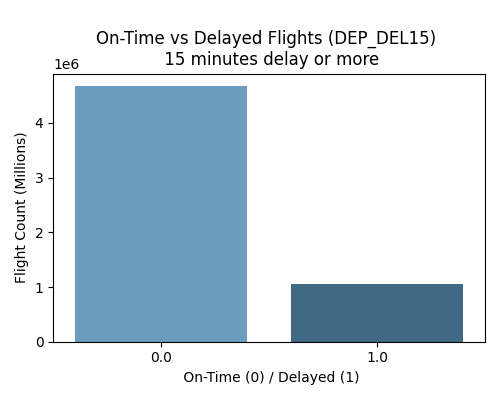

In [0]:
# 1. Target variable imbalance (DEP_DEL15)
dep_del15_counts = (
    df_otpw.groupBy("DEP_DEL15")
    .count()
    .orderBy("DEP_DEL15")
)
dep_del15_pd = dep_del15_counts.toPandas()

plt.figure(figsize=(5, 4))
sns.barplot(
    x="DEP_DEL15",
    y="count",
    data=dep_del15_pd,
    palette="Blues_d",
    hue="DEP_DEL15",
    legend=False
)
plt.title("On-Time vs Delayed Flights (DEP_DEL15) \n 15 minutes delay or more")
plt.xlabel(" On-Time (0) / Delayed (1)")
plt.ylabel("Flight Count (Millions)")
plt.tight_layout()

# Center display
buf = io.BytesIO()
plt.savefig(buf, format="png")
buf.seek(0)
img_base64 = base64.b64encode(buf.read()).decode("utf-8")
plt.close()

display(
    HTML(
        f"<div style='text-align: center;'><img src='data:image/png;base64,{img_base64}'/></div>"
    )
)

This chart shows the same class imbalance pattern in the full 12-month 2015 OTPW dataset as we observed in the 3-month slice: the large majority of flights depart on time (DEP_DEL15 = 0), while a much smaller share are delayed 15+ minutes (DEP_DEL15 = 1). Expanding to one year confirms this split is not a seasonal artifact of winter months but a stable property of U.S. operations across the calendar. The implication for modeling remains the same: accuracy alone will be misleading because a trivial “always on-time” classifier would still score high. Our Phase 2–3 evaluation must stay imbalance-aware (PR-AUC, F₂/recall-weighted metrics) and may require class weighting or calibrated thresholds to avoid systematically missing true delays.


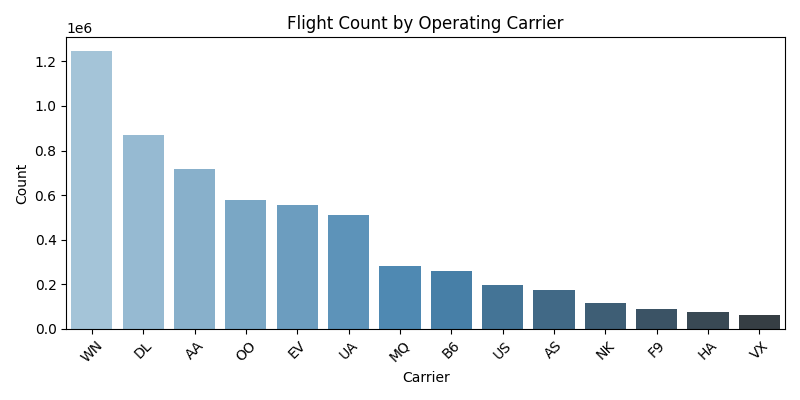

In [0]:
# 2. Unique operating carriers
carrier_counts = df_otpw.groupBy("OP_UNIQUE_CARRIER").count().orderBy(desc("count"))
carrier_pd = carrier_counts.toPandas()
plt.figure(figsize=(8,4))
sns.barplot(x="OP_UNIQUE_CARRIER", 
            y="count", 
            data=carrier_pd, 
            palette="Blues_d",
            hue="OP_UNIQUE_CARRIER",
            legend=False)
plt.title("Flight Count by Operating Carrier")
plt.xlabel("Carrier")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()

# Centering display
buf = io.BytesIO()
plt.savefig(buf, format="png")
buf.seek(0)
img_base64 = base64.b64encode(buf.read()).decode("utf-8")
plt.close()
display(
    HTML(
        f"<div style='text-align: center;'><img src='data:image/png;base64,{img_base64}'/></div>"
    )
)

With the 12-month dataset, carrier concentration becomes even clearer and more reliable than in the 3-month sample. A small set of major U.S. airlines (especially WN, DL, AA, UA, OO, EV) accounts for most rows, while several smaller carriers contribute comparatively few flights. The one-year view confirms that this skew is structural rather than driven by a short seasonal window. For modeling, this means carrier identity can appear highly predictive simply because large carriers dominate training signal, while tail carriers have limited support. To avoid a model that performs well only on top airlines, later results should be reported with carrier-level slices and (if needed) grouped carrier features or smoothing to stabilize performance on low-volume airlines.

#### 3.4.2 Time-Based Delay Patterns


##### 3.4.2.1 Hourly Delay Rate


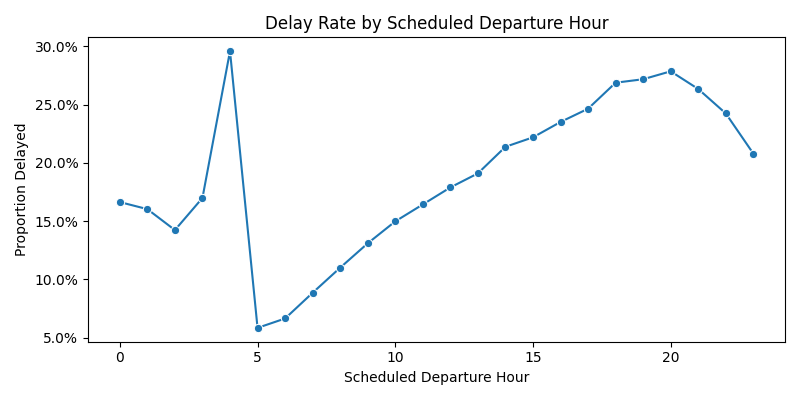

In [0]:
df_otpw = df_otpw.withColumn("CRS_DEP_HOUR", (F.col("CRS_DEP_TIME").cast("int") / 100).cast("int"))

delay_by_hour = (
    df_otpw.groupBy("CRS_DEP_HOUR")
    .agg(F.mean(F.col("DEP_DEL15").cast("double")).alias("delay_rate"))
    .orderBy("CRS_DEP_HOUR")
)
delay_by_hour = df_otpw.groupBy("CRS_DEP_HOUR").agg(mean("DEP_DEL15").alias("delay_rate")).orderBy("CRS_DEP_HOUR")
delay_by_hour_pd = delay_by_hour.toPandas()
plt.figure(figsize=(8,4))
sns.lineplot(x="CRS_DEP_HOUR", y="delay_rate", data=delay_by_hour_pd, marker="o")
plt.title("Delay Rate by Scheduled Departure Hour")
plt.xlabel("Scheduled Departure Hour")
plt.ylabel("Proportion Delayed")
plt.gca().yaxis.set_major_formatter(PercentFormatter(1.0))
plt.tight_layout()

# Centering display
buf = io.BytesIO()
plt.savefig(buf, format="png")
buf.seek(0)
img_base64 = base64.b64encode(buf.read()).decode("utf-8")
plt.close()
display(
    HTML(
        f"<div style='text-align: center;'><img src='data:image/png;base64,{img_base64}'/></div>"
    )
)


**Observation**

The full-year trend reinforces the same propagation pattern observed in the 3-month sample: delay rates are lowest during the early-morning hours, bottoming out around 5–7 AM, and then increase steadily as the day progresses. By mid-afternoon and into the evening, delay rates rise sharply and peak between roughly 17:00 and 20:00, reflecting cumulative congestion and network-wide propagation effects. The 12-month view confirms that this intraday structure is highly stable across seasons and is a fundamental feature of U.S. domestic operations rather than a short-window artifact.

##### 3.4.2.2 Day-of-Week Delay Rate


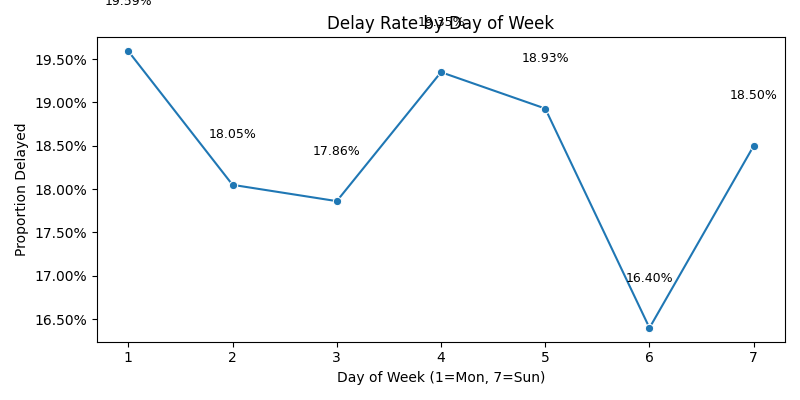

In [0]:
df_otpw = df_otpw.withColumn("DAY_OF_WEEK", (F.col("DAY_OF_WEEK")).cast("int"))

delay_by_day = (
    df_otpw.groupBy("DAY_OF_WEEK")
    .agg(F.mean(F.col("DEP_DEL15").cast("double")).alias("delay_rate"))
    .orderBy("DAY_OF_WEEK")
)
delay_by_day = df_otpw.groupBy("DAY_OF_WEEK").agg(mean("DEP_DEL15").alias("delay_rate")).orderBy("DAY_OF_WEEK")
delay_by_day_pd = delay_by_day.toPandas()
plt.figure(figsize=(8,4))
sns.lineplot(x="DAY_OF_WEEK", y="delay_rate", data=delay_by_day_pd, marker="o")
plt.title("Delay Rate by Day of Week")
plt.xlabel("Day of Week (1=Mon, 7=Sun)")
plt.ylabel("Proportion Delayed")
plt.gca().yaxis.set_major_formatter(PercentFormatter(1.0))
plt.tight_layout()

for x, y in zip(delay_by_day_pd["DAY_OF_WEEK"], delay_by_day_pd["delay_rate"]):
    plt.text(x, y + 0.005, f"{y*100:.2f}%", ha="center", va="bottom", fontsize=9)

# Centering display
buf = io.BytesIO()
plt.savefig(buf, format="png")
buf.seek(0)
img_base64 = base64.b64encode(buf.read()).decode("utf-8")
plt.close()
display(
    HTML(
        f"<div style='text-align: center;'><img src='data:image/png;base64,{img_base64}'/></div>"
    )
)

**Observation**

The full-year data preserves the same weekly pattern seen in the 3-month slice: delay rates tend to be highest at the beginning and end of the week, with Mondays showing the largest proportion of delayed departures and Sundays also elevated. Midweek flights—particularly Tuesday and Wednesday—continue to experience the lowest delay rates, reflecting lighter passenger loads and more operational slack in the middle of the week. This stability across the full 12-month window suggests that day-of-week effects are structural and should be retained as part of the temporal feature set.

#### 3.4.3 Airport Delay Patterns


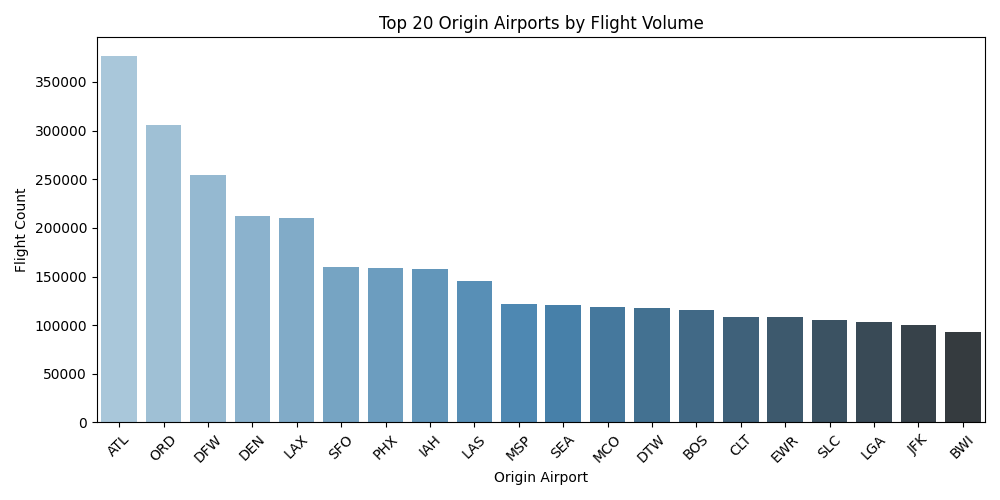

In [0]:
# 4. Flight volume by origin airport (top 20)
top_airports = df_otpw.groupBy("ORIGIN").count().orderBy(desc("count")).limit(20)
top_airports_pd = top_airports.toPandas()
plt.figure(figsize=(10,5))
sns.barplot(x="ORIGIN", 
            y="count", 
            data=top_airports_pd, 
            palette="Blues_d",
            hue="ORIGIN",
            legend=False
            )
plt.title("Top 20 Origin Airports by Flight Volume")
plt.xlabel("Origin Airport")
plt.ylabel("Flight Count")
plt.xticks(rotation=45)
plt.tight_layout()

# Centering display
buf = io.BytesIO()
plt.savefig(buf, format="png")
buf.seek(0)
img_base64 = base64.b64encode(buf.read()).decode("utf-8")
plt.close()
display(
    HTML(
        f"<div style='text-align: center;'><img src='data:image/png;base64,{img_base64}'/></div>"
    )
)

This chart confirms that traffic concentration remains highly skewed in the full 12-month dataset: a small group of major U.S. hubs—most prominently ATL, ORD, DFW, DEN, and LAX—handle the majority of all departures, with each serving well over 200,000 flights across the year. The next tier of airports (SFO, PHX, IAH, LAS, MSP, SEA) also contribute substantial volume but still lag far behind the top three. This year-round consistency strengthens the rationale established in the 3-month analysis: (i) model performance must be evaluated at the airport level, since misclassifications at these large hubs have disproportionately high operational impact; and (ii) engineering airport-specific features such as congestion indicators, local weather joins, and time-of-day interactions is well-justified, as these features influence a large share of the dataset.


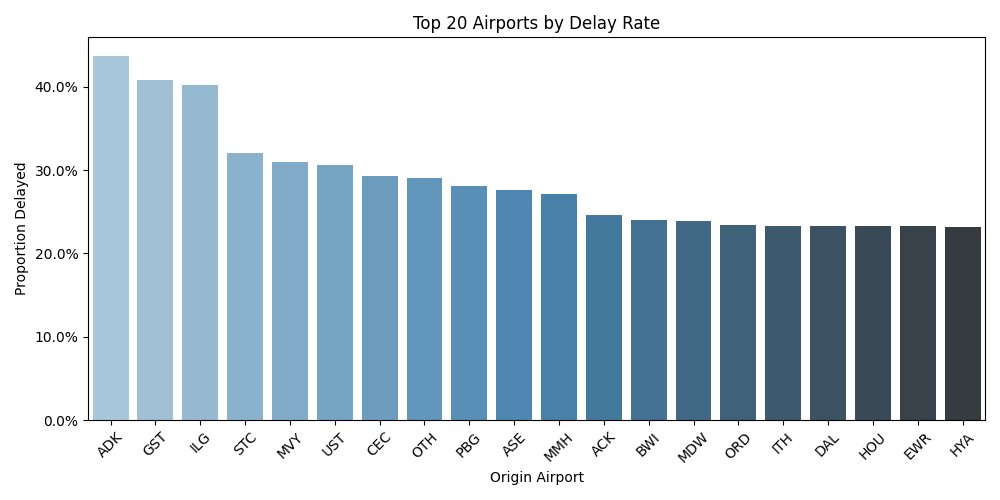

In [0]:
# 5. Delay rate by origin airport (top 10)
delay_by_airport = df_otpw.groupBy("ORIGIN").agg(mean("DEP_DEL15").alias("delay_rate")).orderBy(desc("delay_rate")).limit(20)
delay_by_airport_pd = delay_by_airport.toPandas()
plt.figure(figsize=(10,5))
sns.barplot(x="ORIGIN", y="delay_rate", 
            data=delay_by_airport_pd, 
            palette="Blues_d",
            hue="ORIGIN",
            legend=False
            )
plt.title("Top 20 Airports by Delay Rate")
plt.xlabel("Origin Airport")
plt.ylabel("Proportion Delayed")
plt.gca().yaxis.set_major_formatter(PercentFormatter(1.0))
plt.xticks(rotation=45)
plt.tight_layout()

# Centering display
buf = io.BytesIO()
plt.savefig(buf, format="png")
buf.seek(0)
img_base64 = base64.b64encode(buf.read()).decode("utf-8")
plt.close()
display(
    HTML(
        f"<div style='text-align: center;'><img src='data:image/png;base64,{img_base64}'/></div>"
    )
)

The 12-month results show the same pattern observed in the 3-month slice: several airports with relatively modest traffic volumes exhibit disproportionately high delay rates, with some origins exceeding 40% of departures delayed 15 minutes or more. Meanwhile, many of the major hubs fall closer to the middle of the distribution, reflecting more stable operational performance despite their large volumes. This divergence between volume and delay rate reinforces the need for airport-level evaluation in the modeling stage. If the classifier under-flags chronically delayed stations—especially smaller ones with persistent operational bottlenecks—local teams will perceive the model as unreliable even if global metrics such as PR-AUC or F₂ appear strong. The full-year view confirms that these airport-specific delay patterns are structural and must be accounted for in both feature design and evaluation.

In [0]:
# Convert Spark DataFrame to Pandas and sort by delay rate descending
topN_sorted_by_busiest_pd = (
    topN_sorted_by_busiest
    .orderBy(F.desc("delay_rate_pct"))
    .toPandas()
)

# Create figure and first axis
fig, ax1 = plt.subplots(figsize=(12, 6))

# Bar chart for flight volume
bars = ax1.bar(topN_sorted_by_busiest_pd["ORIGIN"],
               topN_sorted_by_busiest_pd["num_flights"],
               color="orange", alpha=0.8, label="Flight Volume")

# Add labels on bars
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, height + 1000,
             f"{int(height):,}", ha="center", va="bottom", fontsize=9)

# Axis and labels
ax1.set_xlabel("Origin Airport")
ax1.set_ylabel("Flight Volume", color="darkorange", fontsize=12)
ax1.tick_params(axis="y", labelcolor="darkorange")

# Create second axis for delay rate
ax2 = ax1.twinx()
ax2.plot(topN_sorted_by_busiest_pd["ORIGIN"],
         topN_sorted_by_busiest_pd["delay_rate_pct"],
         color="teal", marker="o", linewidth=2, label="Delay Rate (%)")

# Add data labels for delay rate
for x, y in zip(topN_sorted_by_busiest_pd["ORIGIN"], topN_sorted_by_busiest_pd["delay_rate_pct"]):
    ax2.text(x, y + 0.3, f"{y:.2f}%", ha="center", va="bottom", color="teal", fontsize=9)

ax2.set_ylabel("Delay Rate (%)", color="teal", fontsize=12)
ax2.tick_params(axis="y", labelcolor="teal")
ax2.yaxis.set_major_formatter(mtick.PercentFormatter())

# Title and layout
plt.title("Top 20 Busiest Airports Sorted by Delay Rate (%)", fontsize=14, weight="bold")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
File <command-1792055957779556>, line 3
      1 # Convert Spark DataFrame to Pandas and sort by delay rate descending
      2 topN_sorted_by_busiest_pd = (
----> 3     topN_sorted_by_busiest
      4     .orderBy(F.desc("delay_rate_pct"))
      5     .toPandas()
      6 )
      8 # Create figure and first axis
      9 fig, ax1 = plt.subplots(figsize=(12, 6))

NameError: name 'topN_sorted_by_busiest' is not defined

**Observation**

Among the busiest airports, **ORD** (Chicago O’Hare), **ATL** (Atlanta), and **DFW** (Dallas/Fort Worth) 
handle the highest flight volumes but also experience significant delays.  
High delay rates are often observed at major hubs due to **air traffic congestion, 
weather sensitivity, and connecting flight dependencies**.  
Conversely, airports like **PHX** and **SEA** maintain relatively low delay percentages 
despite heavy traffic, suggesting more efficient scheduling and operational management.


#### 3.4.4 Airline Delay Patterns

In [0]:
# --- Airline-level delay statistics with colors matched to airport chart ---
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# Sort by delay rate (or change to num_flights if desired)
pdf = delay_by_carrier.orderBy(F.desc("delay_rate_pct")).toPandas()

fig, ax1 = plt.subplots(figsize=(12, 6))

# Bars: flight volume (orange to match previous chart)
bar_color = "orange"     # same bar color
bars = ax1.bar(
    pdf["OP_UNIQUE_CARRIER"], pdf["num_flights"],
    color=bar_color, alpha=0.85, label="Flight Volume", edgecolor="none"
)

# Bar labels
for b in bars:
    h = b.get_height()
    ax1.text(b.get_x() + b.get_width()/2, h + 3000, f"{int(h):,}",
             ha="center", va="bottom", fontsize=9)

ax1.set_xlabel("Airline (OP_UNIQUE_CARRIER)")
ax1.set_ylabel("Flight Volume", color=bar_color)
ax1.tick_params(axis="x", rotation=45)
ax1.tick_params(axis="y", labelcolor=bar_color)

# Line: delay rate (teal to match previous chart)
line_color = "teal"      # same line color
ax2 = ax1.twinx()
ax2.plot(
    pdf["OP_UNIQUE_CARRIER"], pdf["delay_rate_pct"],
    color=line_color, marker="o", linewidth=2, label="Delay Rate (%)"
)

# Line labels
for x, y in zip(pdf["OP_UNIQUE_CARRIER"], pdf["delay_rate_pct"]):
    ax2.text(x, y + 0.4, f"{y:.2f}%", ha="center", va="bottom",
             fontsize=9, color=line_color)

ax2.set_ylabel("Delay Rate (%)", color=line_color)
ax2.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=100))
ax2.tick_params(axis="y", labelcolor=line_color)

plt.title("Delay Rate vs Flight Volume by Airline (sorted by delay rate)")
fig.tight_layout()
plt.show()


com.databricks.backend.common.rpc.CommandCancelledException
	at com.databricks.spark.chauffeur.ExecContextState.cancel(ExecContextState.scala:434)
	at com.databricks.spark.chauffeur.ExecutionContextManagerV1.cancelExecution(ExecutionContextManagerV1.scala:473)
	at com.databricks.spark.chauffeur.ChauffeurState.$anonfun$process$1(ChauffeurState.scala:750)
	at com.databricks.logging.UsageLogging.$anonfun$recordOperation$1(UsageLogging.scala:510)
	at com.databricks.logging.UsageLogging.executeThunkAndCaptureResultTags$1(UsageLogging.scala:616)
	at com.databricks.logging.UsageLogging.$anonfun$recordOperationWithResultTags$4(UsageLogging.scala:643)
	at com.databricks.logging.AttributionContextTracing.$anonfun$withAttributionContext$1(AttributionContextTracing.scala:49)
	at com.databricks.logging.AttributionContext$.$anonfun$withValue$1(AttributionContext.scala:293)
	at scala.util.DynamicVariable.withValue(DynamicVariable.scala:62)
	at com.databricks.logging.AttributionContext$.withValue(Attr

**Observation**

This dual-axis chart compares **flight volume** (bars) and **delay rate (%)** (line) 
across major U.S. carriers.  
Smaller airlines such as **Frontier (F9)** and **Envoy (MQ)** exhibit 
the highest delay rates (above 28%), possibly due to limited scheduling flexibility 
and resource constraints.  
In contrast, large carriers like **Southwest (WN)**, **American (AA)**, 
and **Delta (DL)** manage far more flights while maintaining moderate delay rates 
(around 16–21%), indicating stronger operational efficiency and network resilience.

#### 3.4.5 Weather Impact on Delays

##### 3.4.5.1 Temperature vs Delay Patterns 

In [0]:
# --- Delay Rate vs Flight Volume by Temperature (bins) ---

# 1) Collect Spark results and sort by temperature bin ascending
pdf = (
    temp_delay               # Spark DF: [Temp_bin, delay_rate_pct, num_flights]
    .orderBy("Temp_bin")
    .toPandas()
)

# 2) Create figure + left axis (flight volume as bars)
fig, ax1 = plt.subplots(figsize=(12, 6))
bar_color  = "orange"   # keep same as previous charts
line_color = "teal"     # keep same as previous charts

bars = ax1.bar(
    pdf["Temp_bin"], pdf["num_flights"],
    color=bar_color, alpha=0.85, label="Flight Volume", width=4.5
)

# Add labels on bars (thin the labels if many bins)
for b in bars:
    h = b.get_height()
    if h > 0:
        ax1.text(b.get_x() + b.get_width()/2, h + 1500, f"{int(h):,}",
                 ha="center", va="bottom", fontsize=8, rotation=90)

ax1.set_xlabel("Temperature Bins (°F)")
ax1.set_ylabel("Flight Volume", color=bar_color)
ax1.tick_params(axis="y", labelcolor=bar_color)

# 3) Right axis (delay rate line)
ax2 = ax1.twinx()
ax2.plot(
    pdf["Temp_bin"], pdf["delay_rate_pct"],
    color=line_color, marker="o", linewidth=2, label="Delay Rate (%)"
)

# Add data labels for the line
for x, y in zip(pdf["Temp_bin"], pdf["delay_rate_pct"]):
    ax2.text(x, y + 0.3, f"{y:.1f}%", ha="center", va="bottom",
             fontsize=8, color=line_color)

ax2.set_ylabel("Delay Rate (%)", color=line_color)
ax2.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=100))
ax2.tick_params(axis="y", labelcolor=line_color)

# Styling
plt.title("Delay Rate vs Flight Volume by Temperature (sorted by Temp_bin)")
plt.tight_layout()
plt.show()


com.databricks.backend.common.rpc.CommandCancelledException
	at com.databricks.spark.chauffeur.ExecContextState.cancel(ExecContextState.scala:434)
	at com.databricks.spark.chauffeur.ExecutionContextManagerV1.cancelExecution(ExecutionContextManagerV1.scala:473)
	at com.databricks.spark.chauffeur.ChauffeurState.$anonfun$process$1(ChauffeurState.scala:750)
	at com.databricks.logging.UsageLogging.$anonfun$recordOperation$1(UsageLogging.scala:510)
	at com.databricks.logging.UsageLogging.executeThunkAndCaptureResultTags$1(UsageLogging.scala:616)
	at com.databricks.logging.UsageLogging.$anonfun$recordOperationWithResultTags$4(UsageLogging.scala:643)
	at com.databricks.logging.AttributionContextTracing.$anonfun$withAttributionContext$1(AttributionContextTracing.scala:49)
	at com.databricks.logging.AttributionContext$.$anonfun$withValue$1(AttributionContext.scala:293)
	at scala.util.DynamicVariable.withValue(DynamicVariable.scala:62)
	at com.databricks.logging.AttributionContext$.withValue(Attr

**Observation**

The chart Delay Rate vs Flight Volume by Temperature reveals a **U-shaped relationship** between temperature and flight delays.  
Flights departing in **moderate temperatures (40–70°F)** experience the **lowest delay rates** (around 12–17%),  
while **extreme cold (below 20°F)**  correspond to **higher delays**, reaching up to **35%**.

##### 3.4.5.2 Wind Speed vs Delay Patterns 

In [0]:
# --- Delay Rate vs Flight Volume by Wind Speed (bins) ---

# 1) Collect Spark results (ensure ascending bins)
pdf = wind_delay.orderBy("Wind_bin").toPandas()   # columns: Wind_bin, delay_rate_pct, num_flights

# 2) Create dual-axis figure
fig, ax1 = plt.subplots(figsize=(12, 6))
bar_color  = "orange"    # match previous charts
line_color = "teal"

# Bars = flight volume
bars = ax1.bar(pdf["Wind_bin"], pdf["num_flights"], color=bar_color, alpha=0.85, width=1.8, label="Flight Volume")
ax1.set_xlabel("Wind Bins (mph)")
ax1.set_ylabel("Flight Volume", color=bar_color)
ax1.tick_params(axis="y", labelcolor=bar_color)

# Optional: thin bar labels if many bins
for b in bars:
    h = b.get_height()
    if h > 0:
        ax1.text(b.get_x() + b.get_width()/2, h + 4000, f"{int(h):,}",
                 ha="center", va="bottom", fontsize=8, rotation=90)

# Line = delay rate (%)
ax2 = ax1.twinx()
ax2.plot(pdf["Wind_bin"], pdf["delay_rate_pct"], color=line_color, marker="o", linewidth=2, label="Delay Rate (%)")
for x, y in zip(pdf["Wind_bin"], pdf["delay_rate_pct"]):
    ax2.text(x, y + 0.4, f"{y:.1f}%", ha="center", va="bottom", fontsize=8, color=line_color)

ax2.set_ylabel("Delay Rate (%)", color=line_color)
ax2.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=100))
ax2.tick_params(axis="y", labelcolor=line_color)

plt.title("Delay Rate vs Flight Volume by Wind Speed (sorted by Wind_bin)")
plt.tight_layout()
plt.show()


com.databricks.backend.common.rpc.CommandCancelledException
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$5(SequenceExecutionState.scala:132)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3(SequenceExecutionState.scala:132)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3$adapted(SequenceExecutionState.scala:129)
	at scala.collection.immutable.Range.foreach(Range.scala:158)
	at com.databricks.spark.chauffeur.SequenceExecutionState.cancel(SequenceExecutionState.scala:129)
	at com.databricks.spark.chauffeur.ExecContextState.cancelRunningSequence(ExecContextState.scala:715)
	at com.databricks.spark.chauffeur.ExecContextState.$anonfun$cancel$1(ExecContextState.scala:435)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.ExecContextState.cancel(ExecContextState.scala:435)
	at com.databricks.spark.chauffeur.ExecutionContextManagerV1.can

**Observation**

Most flights occur under moderate wind speeds (around 5–15 mph), where delay rates remain relatively low.  
As wind speed increases beyond 20 mph, delay rates rise sharply while flight volume drops, suggesting that strong winds significantly disrupt flight operations.

##### 3.4.5.3 Precipitation vs Delay Patterns

To ensure statistical reliability, bins with fewer than 100 flights were excluded, as their delay rates fluctuate excessively due to small sample sizes.
Additionally, the no-precipitation group (0.00 inches) was removed since it represents over 90% of all flights and dominates the visualization.

In [0]:
# --- Delay Rate vs Flight Volume by Precipitation (bins) ---
# Convert Spark DataFrame to Pandas
pdf = precip_filtered.orderBy("Precip_bin").toPandas()

bar_color = "orange"
line_color = "teal"

fig, ax1 = plt.subplots(figsize=(12, 6))

# --- Bar chart for flight volume ---
bars = ax1.bar(pdf["Precip_bin"], pdf["num_flights"], color=bar_color, alpha=0.85, width=0.008)
ax1.set_xlabel("Precipitation Bins (in/hr)")
ax1.set_ylabel("Flight Volume", color=bar_color)
ax1.tick_params(axis="y", labelcolor=bar_color)

# Add data labels on bars
for b in bars:
    h = b.get_height()
    if h > 0:
        ax1.text(b.get_x() + b.get_width()/2, h + 200, f"{int(h):,}", 
                 ha="center", va="bottom", fontsize=8, rotation=90)

# --- Line chart for delay rate ---
ax2 = ax1.twinx()
ax2.plot(pdf["Precip_bin"], pdf["delay_rate_pct"], color=line_color, marker="o", linewidth=2)
ax2.set_ylabel("Delay Rate (%)", color=line_color)
ax2.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=100))
ax2.tick_params(axis="y", labelcolor=line_color)

# Force the right axis to start from 0
upper = float(pdf["delay_rate_pct"].max())
ax2.set_ylim(0, max(10, upper) + 2)

# Add data labels for delay rate
for x, y in zip(pdf["Precip_bin"], pdf["delay_rate_pct"]):
    ax2.text(x, y + 0.3, f"{y:.1f}%", ha="center", va="bottom", fontsize=8, color=line_color)

# --- Title and layout ---
plt.title("Delay Rate vs Flight Volume by Precipitation (sorted by Precip_bin)")
plt.tight_layout()
plt.show()

---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
File <command-1792055957779570>, line 3
      1 # --- Delay Rate vs Flight Volume by Precipitation (bins) ---
      2 # Convert Spark DataFrame to Pandas
----> 3 pdf = precip_filtered.orderBy("Precip_bin").toPandas()
      5 bar_color = "orange"
      6 line_color = "teal"

NameError: name 'precip_filtered' is not defined

**Observation**

After excluding bins with precipitation = 0 and fewer than 100 flights,
the distribution reveals a meaningful relationship between rainfall intensity and flight delays.  

- **Light rain (<0.05 inches)** already shows a mild increase in delay rate (~29%).  
- **Moderate rain (0.10–0.15 inches)** corresponds to a noticeable rise, around **35–40% delay rate**.  
- For **heavier precipitation (>0.20 inches)**, the sample size drops sharply, but the delay rate remains consistently high (30–37%).  

Overall, **delay probability tends to rise with increasing precipitation**, especially once rainfall exceeds **0.10 inches**, indicating that wet weather significantly disrupts flight operations.


#### 3.4.6 Visibility Impact on Delays


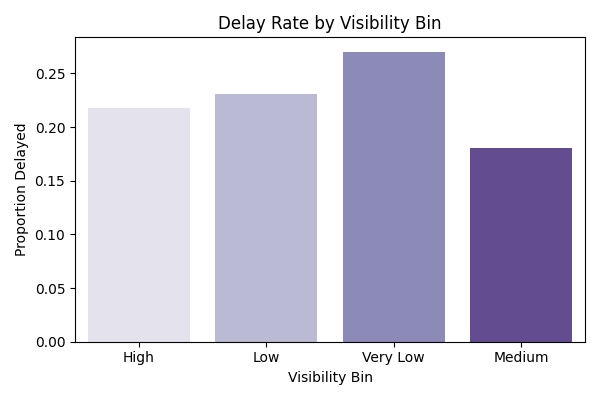

In [0]:
# 7. Delay rate by visibility bins
bins = [0,2,5,10,20]
labels = ["Very Low","Low","Medium","High"]
bin_expr = when(col("HourlyVisibility") <= 2, "Very Low") \
    .when((col("HourlyVisibility") > 2) & (col("HourlyVisibility") <= 5), "Low") \
    .when((col("HourlyVisibility") > 5) & (col("HourlyVisibility") <= 10), "Medium") \
    .otherwise("High")
df_vis_bin = df_otpw.withColumn("Visibility_bin", bin_expr)
vis_delay = df_vis_bin.groupBy("Visibility_bin").agg(mean("DEP_DEL15").alias("delay_rate"))
vis_delay_pd = vis_delay.toPandas()
plt.figure(figsize=(6,4))
sns.barplot(x="Visibility_bin", 
            y="delay_rate", 
            data=vis_delay_pd, 
            palette="Purples",
            hue="Visibility_bin",
            legend=False
            )
plt.title("Delay Rate by Visibility Bin")
plt.xlabel("Visibility Bin")
plt.ylabel("Proportion Delayed")
plt.tight_layout()

# Centering display
buf = io.BytesIO()
plt.savefig(buf, format="png")
buf.seek(0)
img_base64 = base64.b64encode(buf.read()).decode("utf-8")
plt.close()
display(
    HTML(
        f"<div style='text-align: center;'><img src='data:image/png;base64,{img_base64}'/></div>"
    )
)

This plot shows the expected weather signal: flights that depart under very low visibility (≤2 miles) have the highest proportion of 15+ minute delays, and the delay rate steadily improves as visibility increases.

#### 3.4.7 Correlation heatmap


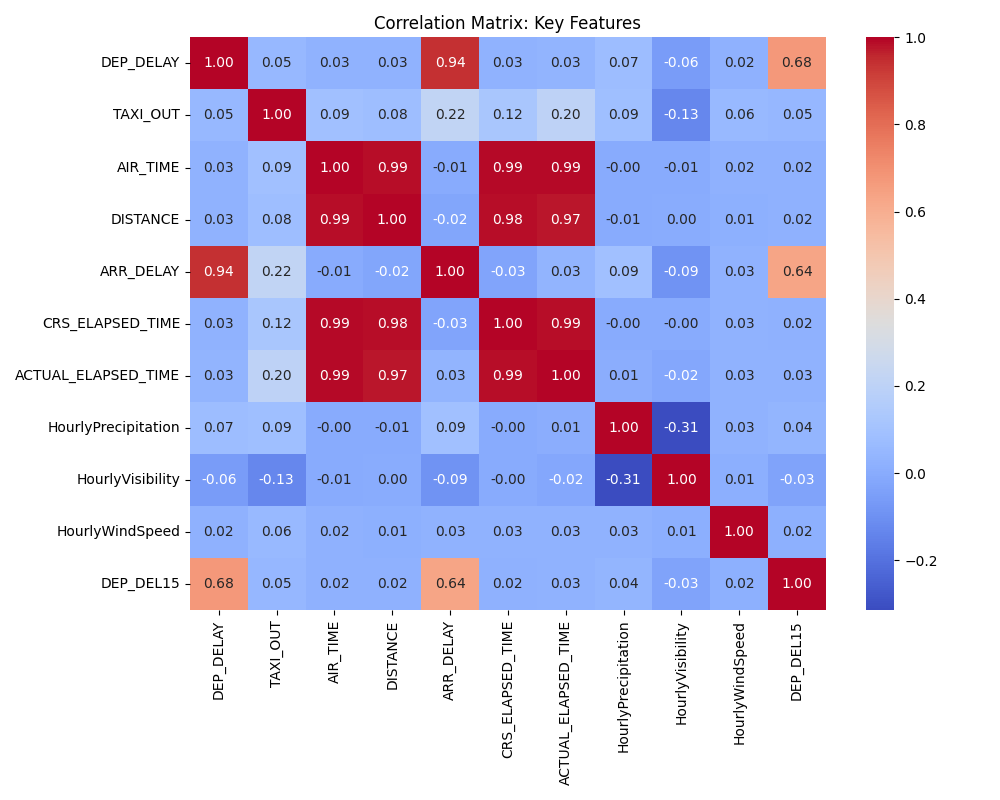

In [0]:
# Correlation heatmap for key numeric features
#df_corr_sample = spark.read.format("csv").option("header","true").load(f"dbfs:/mnt/mids-w261/OTPW_3M_2015.csv")
df_corr_sample = df

corr_cols = [
    "DEP_DELAY", "TAXI_OUT", "AIR_TIME", "DISTANCE",
    "ARR_DELAY", "CRS_ELAPSED_TIME", "ACTUAL_ELAPSED_TIME",
    "HourlyPrecipitation", "HourlyVisibility", "HourlyWindSpeed",
    "DEP_DEL15"
]
sample_df = df_corr_sample.select([col(c).cast("double") for c in corr_cols]).dropna().limit(10000)
sample_pd = sample_df.toPandas()
corr_matrix = sample_pd.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix: Key Features")
plt.tight_layout()

# Centering display
buf = io.BytesIO()
plt.savefig(buf, format="png")
buf.seek(0)
img_base64 = base64.b64encode(buf.read()).decode("utf-8")
plt.close()
display(
    HTML(
        f"<div style='text-align: center;'><img src='data:image/png;base64,{img_base64}'/></div>"
    )
)

In [0]:
# List your entire user directory
response = requests.get(
    f'https://{host_name}/api/2.0/workspace/list',
    headers={'Authorization': f'Bearer {token}'},
    params={'path': '/Users/anabelbasualdo@berkeley.edu'}
)

print("Your user directory contents:")
for obj in response.json().get('objects', []):
    print(f"{obj['object_type']}: {obj['path']}")
import requests
import json

# Get context info
ctx = dbutils.notebook.entry_point.getDbutils().notebook().getContext()
host_name = ctx.tags().get("browserHostName").get()
token = ctx.apiToken().get()

# Use the workspace/get-status API with the folder ID
folder_id = "1739154845297671"

response = requests.get(
    f'https://{host_name}/api/2.0/workspace/get-status',
    headers={'Authorization': f'Bearer {token}'},
    params={'path': f'/Users/anabelbasualdo@berkeley.edu/Charts'}
)

print("Folder info:")
print(json.dumps(response.json(), indent=2))

# Now list the contents
response = requests.get(
    f'https://{host_name}/api/2.0/workspace/list',
    headers={'Authorization': f'Bearer {token}'},
    params={'path': '/Users/anabelbasualdo@berkeley.edu/Charts'}
)

print("\nFolder contents:")
contents = response.json()
print(json.dumps(contents, indent=2))

# Print just the file names for easy copying
if 'objects' in contents:
    print("\n=== File List ===")
    for obj in contents['objects']:
        print(f"{obj['path']}")
import shutil
import os

# Source directory (Workspace)
source_dir = "/Workspace/Users/anabelbasualdo@berkeley.edu/Charts"

# Destination directory (DBFS)
dest_dir = "/dbfs/student-groups/Group_4_4/Charts"

# Create the destination directory if it doesn't exist
os.makedirs(dest_dir, exist_ok=True)

# List of files to copy
files = [
    "delay_rate_vs_flight_volume_precipitation.png",
    "delay_rate_vs_flight_volume_wind_speed.png",
    "delay_rate_vs_flight_volume_temperature.png",
    "flight_count_by_operating_carrier.png",
    "On-Time vs Delayed Flights (DEP_DEL15) 15 minutes delay or more.png",
    "top_20_airport_origin_by_flight_volume.png",
    "top_20_airports_by_delay_rate.png",
    "delay_rate_by_schedlued_departure_date.png",
    "delay_rate_by_day_of_week.png",
    "delay_rate_by_visibility_bin.png",
    "delay_rate_by_flight_volume_by_airline.png",
    "missing_value_percentage_by_column.png",
    "top_20_busiest_airports_sorted_by_delay_rate.png",
    "correlation_matrix.png"
]

# Copy each file
for filename in files:
    source_path = os.path.join(source_dir, filename)
    dest_path = os.path.join(dest_dir, filename)
    
    try:
        shutil.copy2(source_path, dest_path)
        print(f"✓ Copied: {filename}")
    except Exception as e:
        print(f"✗ Error copying {filename}: {str(e)}")

print(f"\n=== Copy Complete ===")
print(f"Files copied to: dbfs:/student-groups/Group_4_4/Charts/")

# Verify the files are there
print("\nVerifying files in destination:")
dbutils.fs.ls("dbfs:/student-groups/Group_4_4/Charts/")

---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
File <command-1792055957779577>, line 2
      1 # List your entire user directory
----> 2 response = requests.get(
      3     f'https://{host_name}/api/2.0/workspace/list',
      4     headers={'Authorization': f'Bearer {token}'},
      5     params={'path': '/Users/anabelbasualdo@berkeley.edu'}
      6 )
      8 print("Your user directory contents:")
      9 for obj in response.json().get('objects', []):

NameError: name 'requests' is not defined

In [0]:
from IPython.display import display, Image, Markdown

CHARTS = "/dbfs/student-groups/Group_4_4/Charts/phase2"

# ------------------------------------------------------------
display(Markdown("## Missing Value Percentage By Column"))
display(Image(filename=f"{CHARTS}/missing_value_percentage_by_column_full.png"))
display(Image(filename=f"{CHARTS}/missing_value_percentage_by_column_3m.png"))
display(Markdown(
"""This plot summarizes completeness across all features in OTPW.
The side-by-side view shows that missingness patterns are stable across the 3-month slice and full year,
with a long tail of sparse weather and station fields. These columns should be dropped or imputed selectively
to avoid bloating feature space without adding signal."""
))
display(Markdown("---"))

# ------------------------------------------------------------
display(Markdown("## On-Time vs Delayed Flights (DEP_DEL15)"))
display(Image(filename=f"{CHARTS}/dep_del15_balance_full.png"))
display(Image(filename=f"{CHARTS}/dep_del15_balance_3m.png"))
display(Markdown(
"""Flights are heavily imbalanced, with delayed flights forming a minority class.
This motivates recall-friendly evaluation (PR-AUC, F₂) and potential class-weighting."""
))
display(Markdown("---"))

# ------------------------------------------------------------
display(Markdown("## Flight Count By Operating Carrier"))
display(Image(filename=f"{CHARTS}/flight_count_by_operating_carrier_full.png"))
display(Image(filename=f"{CHARTS}/flight_count_by_operating_carrier_3m.png"))
display(Markdown(
"""A small set of major carriers dominates volume in both slices.
We will report metrics by carrier to ensure performance generalizes beyond the top airlines."""
))
display(Markdown("---"))

# ------------------------------------------------------------
display(Markdown("## Delay Rate By Scheduled Departure Date"))
display(Image(filename=f"{CHARTS}/delay_rate_by_scheduled_departure_date_full.png"))
display(Image(filename=f"{CHARTS}/delay_rate_by_scheduled_departure_date_3m.png"))
display(Markdown(
"""Delay rate varies over time, reflecting seasonality and irregular disruption events.
The 3-month pattern mirrors the year-level trend but with sharper peaks."""
))
display(Markdown("---"))

# ------------------------------------------------------------
display(Markdown("## Delay Rate By Day Of Week"))
display(Image(filename=f"{CHARTS}/delay_rate_by_day_of_week_full.png"))
display(Image(filename=f"{CHARTS}/delay_rate_by_day_of_week_3m.png"))
display(Markdown(
"""Delays are highest on Mondays and weekends, lowest mid-week.
These stable weekly patterns support day-of-week features."""
))
display(Markdown("---"))

# ------------------------------------------------------------
display(Markdown("## Top 20 Airport Origin By Flight Volume"))
display(Image(filename=f"{CHARTS}/top_20_airport_origin_by_flight_volume_full.png"))
display(Image(filename=f"{CHARTS}/top_20_airport_origin_by_flight_volume_3m.png"))
display(Markdown(
"""Traffic is concentrated in major hubs (ATL, ORD, DFW, DEN, LAX, etc.).
Airport-level features are therefore high-leverage for model performance."""
))
display(Markdown("---"))

# ------------------------------------------------------------
display(Markdown("## Top 20 Airports By Delay Rate"))
display(Image(filename=f"{CHARTS}/top_20_airports_by_delay_rate_full.png"))
display(Image(filename=f"{CHARTS}/top_20_airports_by_delay_rate_3m.png"))
display(Markdown(
"""Some modest-volume airports exhibit high chronic delay rates.
We will slice confusion matrices by airport to ensure reliability at these stations."""
))
display(Markdown("---"))

# ------------------------------------------------------------
display(Markdown("## Top 20 Busiest Airports Sorted By Delay Rate"))
display(Image(filename=f"{CHARTS}/top_20_busiest_airports_sorted_by_delay_rate_full.png"))
display(Image(filename=f"{CHARTS}/top_20_busiest_airports_sorted_by_delay_rate_3m.png"))
display(Markdown(
"""Among high-volume hubs, delay rates vary substantially, reflecting differences in congestion and local weather.
This supports congestion and rolling delay features."""
))
display(Markdown("---"))

# ------------------------------------------------------------
display(Markdown("## Delay Rate vs Flight Volume by Temperature"))
display(Image(filename=f"{CHARTS}/delay_rate_vs_flight_volume_temperature_full.png"))
display(Image(filename=f"{CHARTS}/delay_rate_vs_flight_volume_temperature_3m.png"))
display(Markdown(
"""Temperature shows a U-shaped relationship with delays: moderate temps minimize delay risk,
while extremes increase disruption probability."""
))
display(Markdown("---"))

# ------------------------------------------------------------
display(Markdown("## Delay Rate vs Flight Volume by Wind Speed"))
display(Image(filename=f"{CHARTS}/delay_rate_vs_flight_volume_wind_speed_full.png"))
display(Image(filename=f"{CHARTS}/delay_rate_vs_flight_volume_wind_speed_3m.png"))
display(Markdown(
"""Higher winds reduce volume but sharply increase delay rates, indicating operational sensitivity to wind events."""
))
display(Markdown("---"))

# ------------------------------------------------------------
display(Markdown("## Delay Rate vs Flight Volume by Precipitation"))
display(Image(filename=f"{CHARTS}/delay_rate_vs_flight_volume_precipitation_full.png"))
display(Image(filename=f"{CHARTS}/delay_rate_vs_flight_volume_precipitation_3m.png"))
display(Markdown(
"""After excluding zero-precipitation and sparse bins, delay probability rises with increasing rainfall,
highlighting precipitation as a meaningful disruption signal."""
))
display(Markdown("---"))

# ------------------------------------------------------------
display(Markdown("## Delay Rate By Visibility Bin"))
display(Image(filename=f"{CHARTS}/delay_rate_by_visibility_bin_full.png"))
display(Image(filename=f"{CHARTS}/delay_rate_by_visibility_bin_3m.png"))
display(Markdown(
"""Delay rates are highest at very low visibility and improve monotonically as visibility increases,
matching expected aviation operations behavior."""
))
display(Markdown("---"))

# ------------------------------------------------------------
display(Markdown("## Correlation Matrix (Pearson, top numeric features)"))
display(Image(filename=f"{CHARTS}/correlation_matrix_full.png"))
display(Image(filename=f"{CHARTS}/correlation_matrix_3m.png"))
display(Markdown(
"""Operational/post-departure fields are strongly correlated with each other and the target,
so they must be time-gated to avoid leakage. Weather signals are weaker alone but useful in context."""
))
